In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import random
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import re

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:

# Part 1: Data Generation and Preprocessing
class ArithmeticDataset(Dataset):
    def __init__(self, num_examples, max_digits_num1, max_digits_num2, operations=['+', '-'], 
                 generalization=False, gen_digits=None):
        self.examples = []
        self.operations = operations
        
        # Create vocabulary
        self.char_to_idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
        for i in range(10):
            self.char_to_idx[str(i)] = i + 3
        for op in operations:
            self.char_to_idx[op] = len(self.char_to_idx)
        
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Generate examples
        if generalization and gen_digits is not None:
            self.generate_examples(num_examples, gen_digits, gen_digits)
        else:
            self.generate_examples(num_examples, max_digits_num1, max_digits_num2)
    
    def generate_examples(self, num_examples, max_digits_num1, max_digits_num2):
        for _ in range(num_examples):
            # Randomly choose number of digits for first and second numbers
            digits_num1 = random.randint(1, max_digits_num1)
            digits_num2 = random.randint(1, max_digits_num2)
            
            # Generate first and second numbers
            num1 = random.randint(10**(digits_num1-1), 10**digits_num1 - 1) if digits_num1 > 1 else random.randint(0, 9)
            num2 = random.randint(10**(digits_num2-1), 10**digits_num2 - 1) if digits_num2 > 1 else random.randint(0, 9)
            
            # Ensure num1 >= num2 for subtraction to avoid negative results
            if '-' in self.operations:
                if random.choice(self.operations) == '-':
                    num1, num2 = max(num1, num2), min(num1, num2)
            
            # Randomly choose operation
            op = random.choice(self.operations)
            
            # Calculate result
            if op == '+':
                result = num1 + num2
            else:  # op == '-'
                result = num1 - num2
            
            # Create input and target strings
            input_str = f"{num1}{op}{num2}"
            target_str = str(result)
            
            # Convert strings to token sequences with <sos> and <eos>
            input_tokens = ['<sos>'] + list(input_str) + ['<eos>']
            target_tokens = ['<sos>'] + list(target_str) + ['<eos>']
            
            # Convert tokens to indices
            input_indices = [self.char_to_idx[token] for token in input_tokens]
            target_indices = [self.char_to_idx[token] for token in target_tokens]
            
            self.examples.append((input_indices, target_indices, input_str, target_str))
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        return self.examples[idx]

In [28]:
# def create_data_loaders(batch_size=32, train_size=10000, val_size=1000, test_size=1000, 
#                         max_digits_num1=4, max_digits_num2=4, operations=['+', '-']):
#     # Create datasets
#     train_dataset = ArithmeticDataset(train_size, max_digits_num1, max_digits_num2, operations)
#     val_dataset = ArithmeticDataset(val_size, max_digits_num1, max_digits_num2, operations)
#     test_dataset = ArithmeticDataset(test_size, max_digits_num1, max_digits_num2, operations)
    
#     # Create dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
#                              collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, 
#                            collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, 
#                             collate_fn=collate_fn)
    
#     # Create a generalization dataset with more digits than training
#     gen_dataset = ArithmeticDataset(test_size, max_digits_num1+2, max_digits_num2+2, 
#                                    operations, generalization=True, gen_digits=max_digits_num1+2)
#     gen_loader = DataLoader(gen_dataset, batch_size=batch_size, 
#                            collate_fn=collate_fn)
    
#     return train_loader, val_loader, test_loader, gen_loader, train_dataset.vocab_size, train_dataset
# def create_data_loaders(batch_size=32, train_size=10000, val_size=1000, test_size=1000, 
#                         max_digits_num1=3, max_digits_num2=3, operations=['+', '-']):
#     # Create datasets
#     train_dataset = ArithmeticDataset(train_size, max_digits_num1, max_digits_num2, operations)
#     val_dataset = ArithmeticDataset(val_size, max_digits_num1, max_digits_num2, operations)
#     test_dataset = ArithmeticDataset(test_size, max_digits_num1, max_digits_num2, operations)
    
#     # Create a generalization dataset with only 4 and 5 digit numbers
#     gen_dataset = ArithmeticDataset(test_size, 5, 5, operations)
    
#     # Specifically create examples with only 4 and 5 digit numbers
#     gen_dataset.examples = []
#     gen_dataset.generate_examples(test_size // 2, 4, 4)  # 4-digit numbers
#     gen_dataset.generate_examples(test_size // 2, 5, 5)  # 5-digit numbers
    
#     # Create dataloaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
#                              collate_fn=collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, 
#                            collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, 
#                             collate_fn=collate_fn)
#     gen_loader = DataLoader(gen_dataset, batch_size=batch_size, 
#                            collate_fn=collate_fn)
def create_data_loaders(batch_size=32, train_size=10000, val_size=1000, test_size=1000, 
                        max_digits_num1=3, max_digits_num2=3, operations=['+', '-']):
    # Create datasets
    train_dataset = ArithmeticDataset(train_size, max_digits_num1, max_digits_num2, operations)
    val_dataset = ArithmeticDataset(val_size, max_digits_num1, max_digits_num2, operations)
    test_dataset = ArithmeticDataset(test_size, max_digits_num1, max_digits_num2, operations)
    
    # Create an empty generalization dataset
    gen_dataset = ArithmeticDataset(0, 5, 5, operations)  # Initialize with 0 examples
    gen_dataset.examples = []
    
    # Create exactly half with 4-digit numbers and half with 5-digit numbers
    for _ in range(test_size // 2):
        # Generate 4-digit numbers (both operands)
        num1 = random.randint(1000, 9999)  # 4-digit
        num2 = random.randint(1000, 9999)  # 4-digit
        
        # Ensure num1 >= num2 for subtraction to avoid negative results
        if '-' in operations:
            if random.choice(operations) == '-':
                num1, num2 = max(num1, num2), min(num1, num2)
        
        # Randomly choose operation
        op = random.choice(operations)
        
        # Calculate result
        if op == '+':
            result = num1 + num2
        else:  # op == '-'
            result = num1 - num2
        
        # Create input and target strings
        input_str = f"{num1}{op}{num2}"
        target_str = str(result)
        
        # Convert strings to token sequences with <sos> and <eos>
        input_tokens = ['<sos>'] + list(input_str) + ['<eos>']
        target_tokens = ['<sos>'] + list(target_str) + ['<eos>']
        
        # Convert tokens to indices
        input_indices = [gen_dataset.char_to_idx[token] for token in input_tokens]
        target_indices = [gen_dataset.char_to_idx[token] for token in target_tokens]
        
        gen_dataset.examples.append((input_indices, target_indices, input_str, target_str))
    
    for _ in range(test_size // 2):
        # Generate 5-digit numbers (both operands)
        num1 = random.randint(10000, 99999)  # 5-digit
        num2 = random.randint(10000, 99999)  # 5-digit
        
        # Ensure num1 >= num2 for subtraction to avoid negative results
        if '-' in operations:
            if random.choice(operations) == '-':
                num1, num2 = max(num1, num2), min(num1, num2)
        
        # Randomly choose operation  
        op = random.choice(operations)
        
        # Calculate result
        if op == '+':
            result = num1 + num2
        else:  # op == '-'
            result = num1 - num2
        
        # Create input and target strings
        input_str = f"{num1}{op}{num2}"
        target_str = str(result)
        
        # Convert strings to token sequences with <sos> and <eos>
        input_tokens = ['<sos>'] + list(input_str) + ['<eos>']
        target_tokens = ['<sos>'] + list(target_str) + ['<eos>']
        
        # Convert tokens to indices
        input_indices = [gen_dataset.char_to_idx[token] for token in input_tokens]
        target_indices = [gen_dataset.char_to_idx[token] for token in target_tokens]
        
        gen_dataset.examples.append((input_indices, target_indices, input_str, target_str))
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            collate_fn=collate_fn)
    gen_loader = DataLoader(gen_dataset, batch_size=batch_size, 
                           collate_fn=collate_fn)
    
    # Save datasets and vocabulary
    import pickle
    
    # Save vocabulary
    vocab_data = {
        'char_to_idx': train_dataset.char_to_idx,
        'idx_to_char': train_dataset.idx_to_char,
        'vocab_size': train_dataset.vocab_size
    }
    
    with open('arithmetic_vocab.pkl', 'wb') as f:
        pickle.dump(vocab_data, f)
    
    # Save datasets
    datasets = {
        'train': train_dataset.examples,
        'val': val_dataset.examples,
        'test': test_dataset.examples,
        'gen': gen_dataset.examples
    }
    
    with open('arithmetic_datasets.pkl', 'wb') as f:
        pickle.dump(datasets, f)
    
    print("Datasets and vocabulary saved to 'arithmetic_datasets.pkl' and 'arithmetic_vocab.pkl'")
    
    return train_loader, val_loader, test_loader, gen_loader, train_dataset.vocab_size, train_dataset
    
def collate_fn(batch):
    # Sort batch by input sequence length (for PackedSequence)
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    
    # Unzip batch
    input_indices, target_indices, input_strs, target_strs = zip(*batch)
    
    # Get max sequence lengths
    max_input_len = max(len(seq) for seq in input_indices)
    max_target_len = max(len(seq) for seq in target_indices)
    
    # Pad sequences
    padded_inputs = [seq + [0] * (max_input_len - len(seq)) for seq in input_indices]
    padded_targets = [seq + [0] * (max_target_len - len(seq)) for seq in target_indices]
    
    # Convert to tensors
    inputs = torch.LongTensor(padded_inputs).to(device)
    targets = torch.LongTensor(padded_targets).to(device)
    
    return inputs, targets, input_strs, target_strs

# Part 2: Transformer Model Implementation
class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    """Generic N layer decoder with masking."""
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class EncoderLayer(nn.Module):
    """Encoder is made up of self-attn and feed forward"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """Follow Figure 1 (left) for connections."""
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class DecoderLayer(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward"""
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        """Follow Figure 1 (right) for connections."""
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """Take in model size and number of heads."""
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """Implements Figure 2"""
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    """Implements FFN equation."""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    """Implement the PE function."""
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class LayerNorm(nn.Module):
    """Construct a layernorm module."""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size."""
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        """Take in and process masked src and target sequences."""
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention'"""
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

def subsequent_mask(size):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """Helper: Construct a model from hyperparameters."""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

class Batch:
    """Object for holding a batch of data with mask during training."""
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        """Create a mask to hide padding and future words."""
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

class SimpleLossCompute:
    """A simple loss compute and train function."""
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        return loss.item() * norm

# Part 3: Training and Evaluation
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """Greedy decode function."""
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data).long()
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == 2:  # <eos>
            break
    return ys

def evaluate_model(model, data_loader, dataset):
    """Evaluate model on a given dataset."""
    model.eval()
    exact_match = 0
    char_level_correct = 0
    char_level_total = 0
    
    perplexity_sum = 0
    batch_count = 0
    
    criterion = nn.NLLLoss(reduction='sum', ignore_index=0)
    
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Evaluating"):
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            # For perplexity
            out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
            loss = criterion(model.generator(out.contiguous().view(-1, out.size(-1))),
                             batch.trg_y.contiguous().view(-1))
            
            perplexity = math.exp(loss.item() / batch.ntokens)
            perplexity_sum += perplexity
            batch_count += 1
            
            # For exact match and char-level accuracy
            for i in range(batch_size):
                # Greedy decode
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)  # <sos> = 1
                
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):  # Skip <sos>
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                # Compare with target
                target_tokens = []
                for j in range(1, len(tgt[i])):  # Skip <sos>
                    idx = tgt[i][j].item()
                    if idx == 0 or idx == 2:  # <pad> or <eos>
                        break
                    target_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                target_str = ''.join(target_tokens)
                
                # Exact match
                if pred_str == target_str:
                    exact_match += 1
                
                # Character-level accuracy
                min_len = min(len(pred_str), len(target_str))
                char_level_correct += sum(1 for j in range(min_len) if pred_str[j] == target_str[j])
                char_level_total += max(len(pred_str), len(target_str))
    
    # Calculate metrics
    exact_match_acc = exact_match / len(data_loader.dataset)
    char_level_acc = char_level_correct / char_level_total if char_level_total > 0 else 0
    avg_perplexity = perplexity_sum / batch_count if batch_count > 0 else float('inf')
    
    return {
        'exact_match_accuracy': exact_match_acc,
        'char_level_accuracy': char_level_acc,
        'perplexity': avg_perplexity
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    """Train the model with early stopping."""
    train_losses = []
    val_metrics = []
    best_val_acc = 0
    patience_counter = 0
    best_model = None
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for src, tgt, _, _ in train_loader_tqdm:
            batch = Batch(src, tgt, pad=0)
            
            optimizer.zero_grad()
            
            # Forward pass
            output = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
            
            # Calculate loss
            loss = criterion(model.generator(output.contiguous().view(-1, output.size(-1))), 
                            batch.trg_y.contiguous().view(-1))
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            # Update total loss
            total_loss += loss.item()
            
            # Update progress bar
            train_loader_tqdm.set_postfix(loss=loss.item())
        
        # Calculate average training loss
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_metric = evaluate_model(model, val_loader, train_loader.dataset)
        val_metrics.append(val_metric)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Validation Metrics: Exact Match Acc={val_metric['exact_match_accuracy']:.4f}, "
              f"Char-Level Acc={val_metric['char_level_accuracy']:.4f}, "
              f"Perplexity={val_metric['perplexity']:.4f}")
        
        # Early stopping
        if val_metric['exact_match_accuracy'] > best_val_acc:
            best_val_acc = val_metric['exact_match_accuracy']
            patience_counter = 0
            best_model = copy.deepcopy(model.state_dict())
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metric,
            }, 'best_arithmetic_transformer_4.pt')
            print(f"Model saved at epoch {epoch+1}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, train_losses, val_metrics

# def analyze_errors(model, data_loader, dataset, max_examples=10):
#     """Analyze errors made by the model."""
#     model.eval()
#     errors = []
    
#     with torch.no_grad():
#         for src, tgt, input_strs, target_strs in data_loader:
#             batch = Batch(src, tgt, pad=0)
#             batch_size = src.size(0)
            
#             for i in range(batch_size):
#                 # Greedy decode
#                 model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
#                                          max_len=20, start_symbol=1)  # <sos> = 1
                
#                 # Convert to tokens
#                 pred_tokens = []
#                 for j in range(1, model_out.size(1)):  # Skip <sos>
#                     idx = model_out[0, j].item()
#                     if idx == 2:  # <eos>
#                         break
#                     pred_tokens.append(dataset.idx_to_char[idx])
                
#                 pred_str = ''.join(pred_tokens)
                
#                 # If prediction is wrong, add to errors
#                 if pred_str != target_strs[i]:
#                     errors.append({
#                         'input': input_strs[i],
#                         'target': target_strs[i],
#                         'prediction': pred_str,
#                         'input_length': len(input_strs[i]),
#                         'has_carry': '+' in input_strs[i] and any(int(input_strs[i].split('+')[0][j]) + int(input_strs[i].split('+')[1][j]) >= 10 
#                                                             for j in range(min(len(input_strs[i].split('+')[0]), len(input_strs[i].split('+')[1])))),
#                         'has_borrow': '-' in input_strs[i] and any(int(input_strs[i].split('-')[0][j]) < int(input_strs[i].split('-')[1][j])
#                                                              for j in range(min(len(input_strs[i].split('-')[0]), len(input_strs[i].split('-')[1]))))
#                     })
                
#                 # Limit number of examples
#                 if len(errors) >= max_examples:
#                     break
            
#             if len(errors) >= max_examples:
#                 break
    
#     return errors

# def analyze_by_input_length(model, data_loader, dataset):
#     """Analyze performance by input length."""
#     model.eval()
#     length_metrics = {}
    
#     with torch.no_grad():
#         for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Analyzing by length"):
#             batch = Batch(src, tgt, pad=0)
#             batch_size = src.size(0)
            
#             for i in range(batch_size):
#                 # Greedy decode
#                 model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
#                                          max_len=20, start_symbol=1)  # <sos> = 1
                
#                 # Convert to tokens
#                 pred_tokens = []
#                 for j in range(1, model_out.size(1)):  # Skip <sos>
#                     idx = model_out[0, j].item()
#                     if idx == 2:  # <eos>
#                         break
#                     pred_tokens.append(dataset.idx_to_char[idx])
                
#                 pred_str = ''.join(pred_tokens)
                
#                 # Get input length
#                 input_len = len(input_strs[i])
                
#                 # Update metrics for this length
#                 if input_len not in length_metrics:
#                     length_metrics[input_len] = {'correct': 0, 'total': 0}
                
#                 length_metrics[input_len]['total'] += 1
#                 if pred_str == target_strs[i]:
#                     length_metrics[input_len]['correct'] += 1
    
#     # Calculate accuracy by length
#     for length, metrics in length_metrics.items():
#         metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
#     return length_metrics

# def analyze_by_operation(model, data_loader, dataset):
#     """Analyze performance by operation (+ or -)."""
#     model.eval()
#     operation_metrics = {'+': {'correct': 0, 'total': 0},
#                          '-': {'correct': 0, 'total': 0}}
    
#     with torch.no_grad():
#         for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Analyzing by operation"):
#             batch = Batch(src, tgt, pad=0)
#             batch_size = src.size(0)
            
#             for i in range(batch_size):
#                 # Determine operation
#                 operation = '+' if '+' in input_strs[i] else '-'
                
#                 # Greedy decode
#                 model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
#                                          max_len=20, start_symbol=1)
                
#                 # Convert to tokens
#                 pred_tokens = []
#                 for j in range(1, model_out.size(1)):
#                     idx = model_out[0, j].item()
#                     if idx == 2:  # <eos>
#                         break
#                     pred_tokens.append(dataset.idx_to_char[idx])
                
#                 pred_str = ''.join(pred_tokens)
                
#                 # Update metrics for this operation
#                 operation_metrics[operation]['total'] += 1
#                 if pred_str == target_strs[i]:
#                     operation_metrics[operation]['correct'] += 1
    
#     # Calculate accuracy by operation
#     for op, metrics in operation_metrics.items():
#         metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
#     return operation_metrics

# def visualize_results(train_losses, val_metrics, length_metrics, operation_metrics):
#     """Visualize training results and analyses."""
#     # Set seaborn style
#     sns.set(style="whitegrid")
    
#     # Plot training loss and validation metrics
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Training loss
#     ax1.plot(train_losses, label='Training Loss')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.set_title('Training Loss')
#     ax1.legend()
    
#     # Validation metrics
#     epochs = range(1, len(val_metrics) + 1)
#     ax2.plot(epochs, [m['exact_match_accuracy'] for m in val_metrics], label='Exact Match Acc')
#     ax2.plot(epochs, [m['char_level_accuracy'] for m in val_metrics], label='Char-Level Acc')
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Accuracy')
#     ax2.set_title('Validation Metrics')
#     ax2.legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Plot accuracy by input length
#     lengths = sorted(length_metrics.keys())
#     accuracies = [length_metrics[l]['accuracy'] for l in lengths]
    
#     plt.figure(figsize=(10, 5))
#     plt.bar(lengths, accuracies)
#     plt.xlabel('Input Length')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy by Input Length')
#     plt.show()
#     # Plot accuracy by operation
#     operations = list(operation_metrics.keys())
#     op_accuracies = [operation_metrics[op]['accuracy'] for op in operations]
    
#     plt.figure(figsize=(8, 5))
#     plt.bar(operations, op_accuracies)
#     plt.xlabel('Operation')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy by Operation')
#     plt.show()


def analyze_errors(model, data_loader, dataset, max_examples=10):
    """Analyze errors made by the model with detailed categorization."""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in data_loader:
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Greedy decode
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)  # <sos> = 1
                
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):  # Skip <sos>
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                
                # If prediction is wrong, add to errors
                if pred_str != target_strs[i]:
                    # Parse input for detailed analysis
                    input_str = input_strs[i]
                    is_addition = '+' in input_str
                    is_subtraction = '-' in input_str
                    if is_addition:
                        num1, num2 = input_str.split('+')                   
                    else:  # subtraction
                        num1, num2 = input_str.split('-')
                    
                    # Analyze specific error patterns
                    error_info = {
                        'input': input_str,
                        'target': target_strs[i],
                        'prediction': pred_str,
                        'input_length': len(input_str),
                        'operation': '+' if is_addition else '-',
                        
                        # Addition-specific analysis
                        'has_carry': False,
                        'carry_count': 0,
                        
                        # Subtraction-specific analysis
                        'has_borrow': False,
                        'borrow_count': 0,
                        'is_negative_result': is_subtraction and int(num1) < int(num2),
                        
                        # Common analysis
                        'digit_diff': abs(len(target_strs[i]) - len(pred_str)),
                        'magnitude_diff': abs(int(target_strs[i]) - int(pred_str)) if pred_str.isdigit() and target_strs[i].isdigit() else None,
                        'first_digit_error': len(pred_str) > 0 and len(target_strs[i]) > 0 and pred_str[0] != target_strs[i][0],
                        'last_digit_error': len(pred_str) > 0 and len(target_strs[i]) > 0 and pred_str[-1] != target_strs[i][-1],
                    }
                    
                    # Detailed carry analysis for addition
                    if is_addition:
                        carry = 0
                        carry_count = 0
                        
                        # Align numbers for column-wise addition
                        num1_padded = num1.zfill(max(len(num1), len(num2)))
                        num2_padded = num2.zfill(max(len(num1), len(num2)))
                        
                        for j in range(len(num1_padded)-1, -1, -1):
                            column_sum = int(num1_padded[j]) + int(num2_padded[j]) + carry
                            if column_sum >= 10:
                                carry = 1
                                carry_count += 1
                            else:
                                carry = 0
                        
                        error_info['has_carry'] = carry_count > 0
                        error_info['carry_count'] = carry_count
                    
                    # Detailed borrow analysis for subtraction
                    if is_subtraction:
                        # Ensure num1 is padded to be at least as long as num2
                        num1_padded = num1.zfill(max(len(num1), len(num2)))
                        num2_padded = num2.zfill(max(len(num1), len(num2)))
                        
                        borrow = 0
                        borrow_count = 0
                        
                        for j in range(len(num1_padded)-1, -1, -1):
                            digit1 = int(num1_padded[j]) - borrow
                            digit2 = int(num2_padded[j])
                            
                            if digit1 < digit2:
                                borrow = 1
                                borrow_count += 1
                            else:
                                borrow = 0
                        
                        error_info['has_borrow'] = borrow_count > 0
                        error_info['borrow_count'] = borrow_count
                    
                    errors.append(error_info)
                
                # Limit number of examples
                if len(errors) >= max_examples:
                    break
            
            if len(errors) >= max_examples:
                break
    return errors


def analyze_error_patterns(errors):
    """Extract patterns from errors for visualization and analysis."""
    error_patterns = {
        # Operation breakdown
        'addition_errors': 0,
        'subtraction_errors': 0,
        
        # Complexity breakdown
        'carry_errors': 0,
        'borrow_errors': 0,
        'negative_result_errors': 0,
        
        # Error type breakdown
        'first_digit_errors': 0,
        'last_digit_errors': 0,
        'digit_count_errors': 0,
        
        # Severity breakdown
        'small_magnitude_errors': 0,  # Difference < 10
        'medium_magnitude_errors': 0,  # Difference < 100
        'large_magnitude_errors': 0,   # Difference >= 100
    }
    
    for error in errors:
        # Operation breakdown
        if error['operation'] == '+':
            error_patterns['addition_errors'] += 1
        else:
            error_patterns['subtraction_errors'] += 1
        
        # Complexity breakdown
        if error['has_carry']:
            error_patterns['carry_errors'] += 1
        if error['has_borrow']:
            error_patterns['borrow_errors'] += 1
        if error.get('is_negative_result', False):
            error_patterns['negative_result_errors'] += 1
        
        # Error type breakdown
        if error['first_digit_error']:
            error_patterns['first_digit_errors'] += 1
        if error['last_digit_error']:
            error_patterns['last_digit_errors'] += 1
        if error['digit_diff'] > 0:
            error_patterns['digit_count_errors'] += 1
        
        # Severity breakdown
        if error['magnitude_diff'] is not None:
            if error['magnitude_diff'] < 10:
                error_patterns['small_magnitude_errors'] += 1
            elif error['magnitude_diff'] < 100:
                error_patterns['medium_magnitude_errors'] += 1
            else:
                error_patterns['large_magnitude_errors'] += 1
    
    return error_patterns

def analyze_by_complexity(model, data_loader, dataset):
    """Analyze performance by problem complexity (carry, borrow, digits)."""
    model.eval()
    complexity_metrics = {
        'carry': {'correct': 0, 'total': 0},
        'no_carry': {'correct': 0, 'total': 0},
        'borrow': {'correct': 0, 'total': 0},
        'no_borrow': {'correct': 0, 'total': 0},
        'negative_result': {'correct': 0, 'total': 0},
        'positive_result': {'correct': 0, 'total': 0},
    }
    
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Analyzing by complexity"):
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Determine operation and complexity
                input_str = input_strs[i]
                is_addition = '+' in input_str
                is_subtraction = '-' in input_str
                
                if is_addition:
                    num1, num2 = input_str.split('+')
                    
                    # Check for carry
                    has_carry = False
                    carry = 0
                    # Align numbers for column-wise addition
                    num1_padded = num1.zfill(max(len(num1), len(num2)))
                    num2_padded = num2.zfill(max(len(num1), len(num2)))
                    
                    for j in range(len(num1_padded)-1, -1, -1):
                        column_sum = int(num1_padded[j]) + int(num2_padded[j]) + carry
                        if column_sum >= 10:
                            carry = 1
                            has_carry = True
                        else:
                            carry = 0
                    
                    complexity_key = 'carry' if has_carry else 'no_carry'
                    complexity_metrics[complexity_key]['total'] += 1
                    complexity_metrics['positive_result']['total'] += 1
                
                else:  # subtraction
                    num1, num2 = input_str.split('-')
                    
                    # Check for borrow
                    has_borrow = False
                    borrow = 0
                    # Ensure num1 is padded to be at least as long as num2
                    num1_padded = num1.zfill(max(len(num1), len(num2)))
                    num2_padded = num2.zfill(max(len(num1), len(num2)))
                    
                    for j in range(len(num1_padded)-1, -1, -1):
                        digit1 = int(num1_padded[j]) - borrow
                        digit2 = int(num2_padded[j])
                        
                        if digit1 < digit2:
                            borrow = 1
                            has_borrow = True
                        else:
                            borrow = 0
                    
                    is_negative = int(num1) < int(num2)
                    
                    complexity_key = 'borrow' if has_borrow else 'no_borrow'
                    complexity_metrics[complexity_key]['total'] += 1
                    
                    result_key = 'negative_result' if is_negative else 'positive_result'
                    complexity_metrics[result_key]['total'] += 1
                
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                
                # Check if prediction is correct
                is_correct = pred_str == target_strs[i]
                
                # Update metrics based on correctness
                if is_addition:
                    complexity_key = 'carry' if has_carry else 'no_carry'
                    if is_correct:
                        complexity_metrics[complexity_key]['correct'] += 1
                        complexity_metrics['positive_result']['correct'] += 1
                else:  # subtraction
                    complexity_key = 'borrow' if has_borrow else 'no_borrow'
                    if is_correct:
                        complexity_metrics[complexity_key]['correct'] += 1
                        
                        result_key = 'negative_result' if is_negative else 'positive_result'
                        complexity_metrics[result_key]['correct'] += 1
    
    # Calculate accuracy by complexity category
    for category, metrics in complexity_metrics.items():
        metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
    return complexity_metrics


def analyze_by_input_length(model, data_loader, dataset):
    """Analyze performance by input length."""
    model.eval()
    length_metrics = {}
    
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Analyzing by length"):
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Greedy decode
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)  # <sos> = 1
                
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):  # Skip <sos>
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                
                # Get input length
                input_len = len(input_strs[i])
                
                # Update metrics for this length
                if input_len not in length_metrics:
                    length_metrics[input_len] = {'correct': 0, 'total': 0}
                
                length_metrics[input_len]['total'] += 1
                if pred_str == target_strs[i]:
                    length_metrics[input_len]['correct'] += 1
    
    # Calculate accuracy by length
    for length, metrics in length_metrics.items():
        metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
    return length_metrics

def analyze_by_operation(model, data_loader, dataset):
    """Analyze performance by operation (+ or -)."""
    model.eval()
    operation_metrics = {'+': {'correct': 0, 'total': 0},
                         '-': {'correct': 0, 'total': 0}}
    
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in tqdm(data_loader, desc="Analyzing by operation"):
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Determine operation
                operation = '+' if '+' in input_strs[i] else '-'
                
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)
                
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                
                # Update metrics for this operation
                operation_metrics[operation]['total'] += 1
                if pred_str == target_strs[i]:
                    operation_metrics[operation]['correct'] += 1
    
    # Calculate accuracy by operation
    for op, metrics in operation_metrics.items():
        metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
    return operation_metrics

def visualize_results(train_losses, val_metrics, length_metrics, operation_metrics, complexity_metrics=None, error_patterns=None):
    """Visualize training results and extended analyses."""
    # Set seaborn style
    sns.set(style="whitegrid")
    
    # Create a 2x2 grid for the main visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # Training loss
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True)
    
    # Validation metrics
    ax2 = fig.add_subplot(2, 2, 2)
    epochs = range(1, len(val_metrics) + 1)
    ax2.plot(epochs, [m['exact_match_accuracy'] for m in val_metrics], 
             label='Exact Match Acc', color='green', linewidth=2)
    ax2.plot(epochs, [m['char_level_accuracy'] for m in val_metrics], 
             label='Char-Level Acc', color='orange', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Validation Metrics', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True)
    
    # Accuracy by input length
    ax3 = fig.add_subplot(2, 2, 3)
    lengths = sorted(length_metrics.keys())
    accuracies = [length_metrics[l]['accuracy'] for l in lengths]
    ax3.bar(lengths, accuracies, color='skyblue')
    ax3.set_xlabel('Input Length', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.set_title('Accuracy by Input Length', fontsize=14)
    for i, v in enumerate(accuracies):
        ax3.text(lengths[i], v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
    ax3.set_ylim(0, 1.1)
    
    # Accuracy by operation
    ax4 = fig.add_subplot(2, 2, 4)
    operations = list(operation_metrics.keys())
    op_accuracies = [operation_metrics[op]['accuracy'] for op in operations]
    bars = ax4.bar(operations, op_accuracies, color=['green', 'red'])
    ax4.set_xlabel('Operation', fontsize=12)
    ax4.set_ylabel('Accuracy', fontsize=12)
    ax4.set_title('Accuracy by Operation', fontsize=14)
    for i, v in enumerate(op_accuracies):
        ax4.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
    ax4.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    # Additional visualizations for complexity metrics if provided
    if complexity_metrics:
        plt.figure(figsize=(15, 6))
        
        # Extract categories and accuracies
        categories = list(complexity_metrics.keys())
        complexities = [complexity_metrics[c]['accuracy'] for c in categories]
        
        # Group data for better visualization
        carry_categories = ['carry', 'no_carry']
        carry_accuracies = [complexity_metrics[c]['accuracy'] for c in carry_categories]
        
        borrow_categories = ['borrow', 'no_borrow']
        borrow_accuracies = [complexity_metrics[c]['accuracy'] for c in borrow_categories]
        
        result_categories = ['positive_result', 'negative_result']
        result_accuracies = [complexity_metrics[c]['accuracy'] for c in result_categories]
        
        # Create subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Carry plot
        ax1.bar(carry_categories, carry_accuracies, color=['salmon', 'lightgreen'])
        ax1.set_ylim(0, 1.0)
        ax1.set_title('Accuracy: Carry vs No Carry')
        for i, v in enumerate(carry_accuracies):
            ax1.text(i, v + 0.02, f'{v:.2f}', ha='center')
        
        # Borrow plot
        ax2.bar(borrow_categories, borrow_accuracies, color=['salmon', 'lightgreen'])
        ax2.set_ylim(0, 1.0)
        ax2.set_title('Accuracy: Borrow vs No Borrow')
        for i, v in enumerate(borrow_accuracies):
            ax2.text(i, v + 0.02, f'{v:.2f}', ha='center')
        
        # Result sign plot
        ax3.bar(result_categories, result_accuracies, color=['lightgreen', 'salmon'])
        ax3.set_ylim(0, 1.0)
        ax3.set_title('Accuracy: Positive vs Negative Results')
        for i, v in enumerate(result_accuracies):
            ax3.text(i, v + 0.02, f'{v:.2f}', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    # Visualize error patterns if provided
    if error_patterns:
        # Create a new figure for error patterns
        plt.figure(figsize=(18, 12))
        
        # Group error patterns for visualization
        operation_errors = ['addition_errors', 'subtraction_errors']
        operation_counts = [error_patterns[k] for k in operation_errors]
        
        complexity_errors = ['carry_errors', 'borrow_errors', 'negative_result_errors']
        complexity_counts = [error_patterns[k] for k in complexity_errors]
        
        type_errors = ['first_digit_errors', 'last_digit_errors', 'digit_count_errors']
        type_counts = [error_patterns[k] for k in type_errors]
        
        magnitude_errors = ['small_magnitude_errors', 'medium_magnitude_errors', 'large_magnitude_errors']
        magnitude_counts = [error_patterns[k] for k in magnitude_errors]
        
        # Create a 2x2 grid of subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
        
        # Operation errors
        ax1.bar(operation_errors, operation_counts, color=['blue', 'orange'])
        ax1.set_title('Errors by Operation Type')
        ax1.set_ylabel('Count')
        for i, v in enumerate(operation_counts):
            ax1.text(i, v + 0.5, str(v), ha='center')
        
        # Complexity errors
        ax2.bar(complexity_errors, complexity_counts, color=['red', 'green', 'purple'])
        ax2.set_title('Errors by Problem Complexity')
        ax2.set_ylabel('Count')
        for i, v in enumerate(complexity_counts):
            ax2.text(i, v + 0.5, str(v), ha='center')
        
        # Type errors
        ax3.bar(type_errors, type_counts, color=['teal', 'brown', 'pink'])
        ax3.set_title('Errors by Position')
        ax3.set_ylabel('Count')
        for i, v in enumerate(type_counts):
            ax3.text(i, v + 0.5, str(v), ha='center')
          # Magnitude errors
        ax4.bar(magnitude_errors, magnitude_counts, color=['gold', 'darkblue', 'crimson'])
        ax4.set_title('Errors by Magnitude')
        ax4.set_ylabel('Count')
        for i, v in enumerate(magnitude_counts):
            ax4.text(i, v + 0.5, str(v), ha='center')
        
        plt.tight_layout()
        plt.show()
        
def ablation_study(train_loader, val_loader,test_loader, gen_loader, vocab_size, dataset, ablation_configs):
    """Perform ablation study with different model configurations."""
    results = {}
    
    for name, config in ablation_configs.items():
        print(f"\nTraining model with configuration: {name}")
        
        # Create model with current configuration
        model = make_model(vocab_size, vocab_size, 
                          N=config['N'], 
                          d_model=config['d_model'], 
                          d_ff=config['d_ff'], 
                          h=config['h'],
                          dropout=config['dropout'])
        model.to(device)
        
        # Define criterion and optimizer
        criterion = nn.NLLLoss(ignore_index=0)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.98), eps=1e-9)
        
        # Train model
        model, train_losses, val_metrics = train_model(model, train_loader, val_loader, 
                                                      criterion, optimizer, 
                                                      num_epochs=config['epochs'],
                                                      patience=config['patience'])
        
        # # Store results
        # best_val_metric = max(val_metrics, key=lambda x: x['exact_match_accuracy'])
        # results[name] = {
        #     'best_val_metric': best_val_metric,
        #     'epochs_trained': len(train_losses)
        # }
        # Evaluate on test set
        test_metric = evaluate_model(model, test_loader, dataset)
        
        # Evaluate on generalization set
        gen_metric = evaluate_model(model, gen_loader, dataset)
        
        # Store best validation metric and evaluation results
        best_val_metric = max(val_metrics, key=lambda x: x['exact_match_accuracy'])
        results[name] = {
            'best_val_metric': best_val_metric,
            'test_metric': test_metric,
            'gen_metric': gen_metric,
            'epochs_trained': len(train_losses)
        }
    
    return results
    
def visualize_generalization_results(gen_metrics, model, gen_loader, dataset):
    """Visualize accuracy on generalization dataset by digit length."""
    # Set seaborn style
    sns.set(style="whitegrid")
    
    # Plot overall generalization metrics
    plt.figure(figsize=(10, 5))
    metrics = ['exact_match_accuracy', 'char_level_accuracy']
    values = [gen_metrics[m] for m in metrics]
    
    plt.bar(metrics, values, color=['blue', 'green'])
    plt.ylim(0, 1.0)
    plt.title('Generalization Dataset Metrics')
    plt.ylabel('Accuracy')
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Analyze by digit length (4 vs 5)
    digit_length_metrics = {
        4: {'correct': 0, 'total': 0},
        5: {'correct': 0, 'total': 0}
    }
    
    operation_metrics = {
        '+': {'correct': 0, 'total': 0},
        '-': {'correct': 0, 'total': 0}
    }
    
    model.eval()
    with torch.no_grad():
        for src, tgt, input_strs, target_strs in tqdm(gen_loader, desc="Analyzing generalization"):
            batch = Batch(src, tgt, pad=0)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Determine digit length (based on first number in equation)
                if '+' in input_strs[i]:
                    first_num = input_strs[i].split('+')[0]
                else:  # '-' is in the string
                    first_num = input_strs[i].split('-')[0]
                
                digit_length = len(first_num)
                operation = '+' if '+' in input_strs[i] else '-'
                
                # Greedy decode
                model_out = greedy_decode(model, src[i:i+1], batch.src_mask[i:i+1], 
                                         max_len=20, start_symbol=1)
                
                # Convert to tokens
                pred_tokens = []
                for j in range(1, model_out.size(1)):
                    idx = model_out[0, j].item()
                    if idx == 2:  # <eos>
                        break
                    pred_tokens.append(dataset.idx_to_char[idx])
                
                pred_str = ''.join(pred_tokens)
                
                # Update metrics for this digit length
                if digit_length in digit_length_metrics:
                    digit_length_metrics[digit_length]['total'] += 1
                    if pred_str == target_strs[i]:
                        digit_length_metrics[digit_length]['correct'] += 1
                
                # Update metrics for this operation
                operation_metrics[operation]['total'] += 1
                if pred_str == target_strs[i]:
                    operation_metrics[operation]['correct'] += 1
    
    # Calculate accuracy by digit length
    for length, metrics in digit_length_metrics.items():
        metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
    # Calculate accuracy by operation for gen dataset
    for op, metrics in operation_metrics.items():
        metrics['accuracy'] = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    
    # Plot accuracy by digit length
    plt.figure(figsize=(10, 5))
    lengths = sorted(digit_length_metrics.keys())
    accuracies = [digit_length_metrics[l]['accuracy'] for l in lengths]
    
    plt.bar(lengths, accuracies, color='purple')
    plt.xlabel('Number of Digits')
    plt.ylabel('Accuracy')
    plt.title('Generalization Accuracy by Digit Length')
    plt.ylim(0, 1.0)
    for i, v in enumerate(accuracies):
        plt.text(lengths[i], v + 0.02, f'{v:.4f}', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy by operation for gen dataset
    plt.figure(figsize=(8, 5))
    operations = list(operation_metrics.keys())
    op_accuracies = [operation_metrics[op]['accuracy'] for op in operations]
    
    plt.bar(operations, op_accuracies, color=['orange', 'red'])
    plt.xlabel('Operation')
    plt.ylabel('Accuracy')
    plt.title('Generalization Accuracy by Operation')
    plt.ylim(0, 1.0)
    for i, v in enumerate(op_accuracies):
        plt.text(operations[i], v + 0.02, f'{v:.4f}', ha='center')
    plt.tight_layout()
    plt.show()
    
    return digit_length_metrics, operation_metrics

In [33]:
print("Starting sequence-to-sequence learning with transformers for arithmetic...")
# Hyperparameters
batch_size = 64
train_size = 50000
val_size = 5000
test_size = 5000
max_digits_num1 = 3
max_digits_num2 = 3
operations = ['+', '-']
    
# Model hyperparameters
N = 3  # Number of layers
d_model = 128  # Model dimension
d_ff = 512  # Feed-forward dimension
h = 8  # Number of attention heads
dropout = 0.1

# Training hyperparameters
epochs = 20
patience = 3
lr = 0.0005

Starting sequence-to-sequence learning with transformers for arithmetic...


Creating datasets and dataloaders...
Datasets and vocabulary saved to 'arithmetic_datasets.pkl' and 'arithmetic_vocab.pkl'
Vocabulary size: 15
Training examples: 50000
Validation examples: 5000
Test examples: 5000
Generalization examples: 5000

Example generalization dataset entries:
Example 1: 8112-4047 = 4065
  First number has 4 digits, second number has 4 digits
Example 2: 8509+4052 = 12561
  First number has 4 digits, second number has 4 digits
Example 3: 1599-1451 = 148
  First number has 4 digits, second number has 4 digits
Example 4: 2245+1674 = 3919
  First number has 4 digits, second number has 4 digits
Example 5: 2147-5300 = -3153
  First number has 4 digits, second number has 4 digits


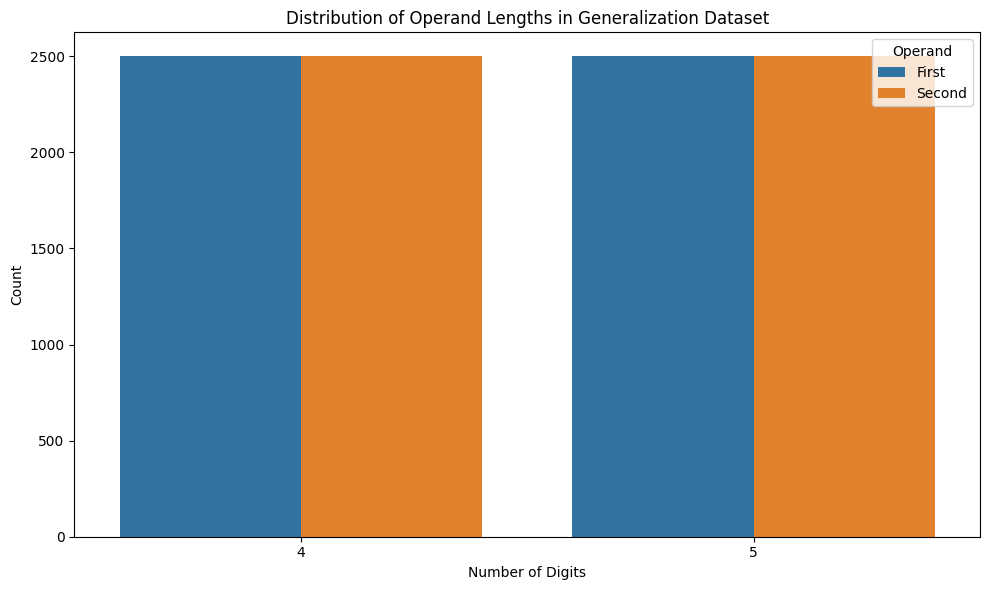

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


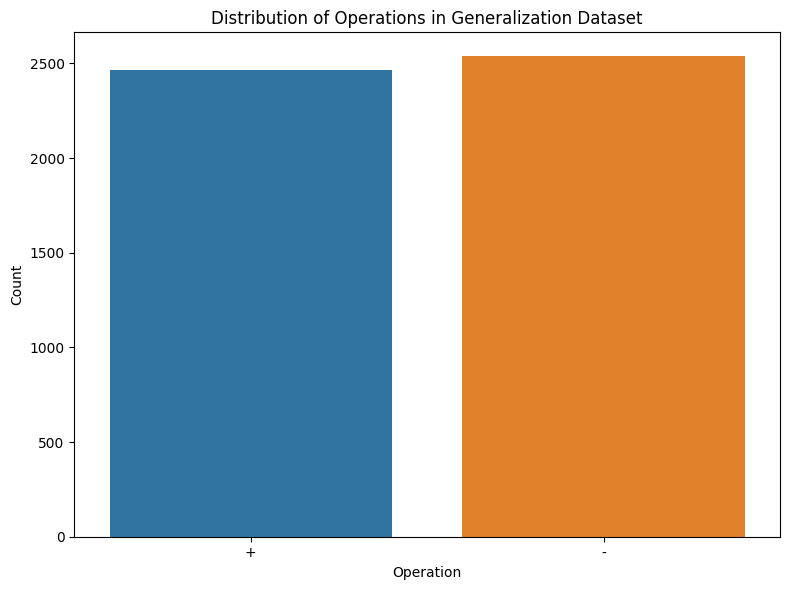

In [18]:
# Create data loaders
print("Creating datasets and dataloaders...")
train_loader, val_loader, test_loader, gen_loader, vocab_size, dataset = \
        create_data_loaders(batch_size, train_size, val_size, test_size,
                           max_digits_num1, max_digits_num2, operations)
    
print(f"Vocabulary size: {vocab_size}")
print(f"Training examples: {len(train_loader.dataset)}")
print(f"Validation examples: {len(val_loader.dataset)}")
print(f"Test examples: {len(test_loader.dataset)}")
print(f"Generalization examples: {len(gen_loader.dataset)}")

print("\nExample generalization dataset entries:")
for i in range(5):
    example = gen_loader.dataset.examples[i]
    input_str = example[2]  # The third element contains the original input string
    target_str = example[3]  # The fourth element contains the original target string
    print(f"Example {i+1}: {input_str} = {target_str}")
    
    # Verify the input operands are indeed 4 or 5 digits
    if '+' in input_str:
        num1, num2 = input_str.split('+')
    else:  # '-' in input_str
        num1, num2 = input_str.split('-')
    print(f"  First number has {len(num1)} digits, second number has {len(num2)} digits")


# Create a count plot for digit lengths in the generalization dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract operand lengths from the generalization dataset
first_operand_lengths = []
second_operand_lengths = []

for example in gen_loader.dataset.examples:
    input_str = example[2]
    if '+' in input_str:
        num1, num2 = input_str.split('+')
    else:  # '-' in input_str
        num1, num2 = input_str.split('-')
    
    first_operand_lengths.append(len(num1))
    second_operand_lengths.append(len(num2))

# Create a DataFrame for plotting
operands_df = pd.DataFrame({
    'Length': first_operand_lengths + second_operand_lengths,
    'Operand': ['First'] * len(first_operand_lengths) + ['Second'] * len(second_operand_lengths)
})

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=operands_df, x='Length', hue='Operand')
plt.title('Distribution of Operand Lengths in Generalization Dataset')
plt.xlabel('Number of Digits')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Also plot the operation distribution
operations_count = {'+': 0, '-': 0}
for example in gen_loader.dataset.examples:
    input_str = example[2]
    if '+' in input_str:
        operations_count['+'] += 1
    else:  # '-' in input_str
        operations_count['-'] += 1

plt.figure(figsize=(8, 6))
sns.barplot(x=list(operations_count.keys()), y=list(operations_count.values()))
plt.title('Distribution of Operations in Generalization Dataset')
plt.xlabel('Operation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [19]:
# Create model
print("Creating transformer model...")
model = make_model(vocab_size, vocab_size, N=N, d_model=d_model, d_ff=d_ff, h=h, dropout=dropout)
model.to(device)

Creating transformer model...


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-2): 3 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=128, out_fe

In [21]:
# Define criterion and optimizer
criterion = nn.NLLLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
# Train model
print("Training model...")
model, train_losses, val_metrics = train_model(model, train_loader, val_loader, 
                                                  criterion, optimizer, num_epochs=epochs,
                                                  patience=patience)

Training model...


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 1/20
Train Loss: 1.1776
Validation Metrics: Exact Match Acc=0.3674, Char-Level Acc=0.5760, Perplexity=2.1929
Model saved at epoch 1


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch 2/20
Train Loss: 0.7892
Validation Metrics: Exact Match Acc=0.6252, Char-Level Acc=0.7828, Perplexity=1.4618
Model saved at epoch 2


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch 3/20
Train Loss: 0.4653
Validation Metrics: Exact Match Acc=0.7594, Char-Level Acc=0.8687, Perplexity=1.2430
Model saved at epoch 3


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 4/20
Train Loss: 0.3102
Validation Metrics: Exact Match Acc=0.8518, Char-Level Acc=0.9233, Perplexity=1.1370
Model saved at epoch 4


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch 5/20
Train Loss: 0.2184
Validation Metrics: Exact Match Acc=0.8840, Char-Level Acc=0.9378, Perplexity=1.1073
Model saved at epoch 5


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 6/20
Train Loss: 0.1684
Validation Metrics: Exact Match Acc=0.9170, Char-Level Acc=0.9542, Perplexity=1.0706
Model saved at epoch 6


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 7/20
Train Loss: 0.1341
Validation Metrics: Exact Match Acc=0.9390, Char-Level Acc=0.9621, Perplexity=1.0569
Model saved at epoch 7


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 8/20
Train Loss: 0.1086
Validation Metrics: Exact Match Acc=0.9600, Char-Level Acc=0.9759, Perplexity=1.0385
Model saved at epoch 8


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch 9/20
Train Loss: 0.0917
Validation Metrics: Exact Match Acc=0.9706, Char-Level Acc=0.9852, Perplexity=1.0287
Model saved at epoch 9


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch 10/20
Train Loss: 0.0786
Validation Metrics: Exact Match Acc=0.9726, Char-Level Acc=0.9839, Perplexity=1.0271
Model saved at epoch 10


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 11/20
Train Loss: 0.0662
Validation Metrics: Exact Match Acc=0.9778, Char-Level Acc=0.9876, Perplexity=1.0221
Model saved at epoch 11


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 12/20
Train Loss: 0.0600
Validation Metrics: Exact Match Acc=0.9834, Char-Level Acc=0.9915, Perplexity=1.0188
Model saved at epoch 12


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 13/20
Train Loss: 0.0532
Validation Metrics: Exact Match Acc=0.9846, Char-Level Acc=0.9918, Perplexity=1.0164
Model saved at epoch 13


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.33s/it]


Epoch 14/20
Train Loss: 0.0474
Validation Metrics: Exact Match Acc=0.9882, Char-Level Acc=0.9949, Perplexity=1.0115
Model saved at epoch 14


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 15/20
Train Loss: 0.0422
Validation Metrics: Exact Match Acc=0.9888, Char-Level Acc=0.9945, Perplexity=1.0093
Model saved at epoch 15


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 16/20
Train Loss: 0.0385
Validation Metrics: Exact Match Acc=0.9876, Char-Level Acc=0.9936, Perplexity=1.0149


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 17/20
Train Loss: 0.0351
Validation Metrics: Exact Match Acc=0.9922, Char-Level Acc=0.9958, Perplexity=1.0093
Model saved at epoch 17


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 18/20
Train Loss: 0.0322
Validation Metrics: Exact Match Acc=0.9952, Char-Level Acc=0.9979, Perplexity=1.0049
Model saved at epoch 18


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 19/20
Train Loss: 0.0300
Validation Metrics: Exact Match Acc=0.9964, Char-Level Acc=0.9978, Perplexity=1.0044
Model saved at epoch 19


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 20/20
Train Loss: 0.0273
Validation Metrics: Exact Match Acc=0.9948, Char-Level Acc=0.9980, Perplexity=1.0039


In [22]:
# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader, dataset)
print(f"Test Metrics: Exact Match Acc={test_metrics['exact_match_accuracy']:.4f}, "
    f"Char-Level Acc={test_metrics['char_level_accuracy']:.4f}, "
    f"Perplexity={test_metrics['perplexity']:.4f}")

Evaluating on test set...


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]

Test Metrics: Exact Match Acc=0.9980, Char-Level Acc=0.9989, Perplexity=1.0028


In [23]:
# Evaluate on generalization set
print("Evaluating on generalization set (longer numbers)...")
gen_metrics = evaluate_model(model, gen_loader, dataset)
print(f"Generalization Metrics: Exact Match Acc={gen_metrics['exact_match_accuracy']:.4f}, "
    f"Char-Level Acc={gen_metrics['char_level_accuracy']:.4f}, "
    f"Perplexity={gen_metrics['perplexity']:.4f}")

Evaluating on generalization set (longer numbers)...


Evaluating: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]

Generalization Metrics: Exact Match Acc=0.0000, Char-Level Acc=0.1533, Perplexity=7202.9410


Analyzing by input length...


Analyzing by length: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Analyzing by operation...


Analyzing by operation: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Performing enhanced error analysis...

Error Pattern Summary:
  addition_errors: 0
  subtraction_errors: 10
  carry_errors: 0
  borrow_errors: 9
  negative_result_errors: 5
  first_digit_errors: 4
  last_digit_errors: 4
  digit_count_errors: 3
  small_magnitude_errors: 2
  medium_magnitude_errors: 1
  large_magnitude_errors: 2

Analyzing by problem complexity...


Analyzing by complexity: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


  carry: 1.0000 (1548/1548)
  no_carry: 1.0000 (1002/1002)
  borrow: 0.9940 (1479/1488)
  no_borrow: 0.9990 (961/962)
  negative_result: 0.9919 (614/619)
  positive_result: 0.9989 (4376/4381)

Visualizing results with enhanced analysis...


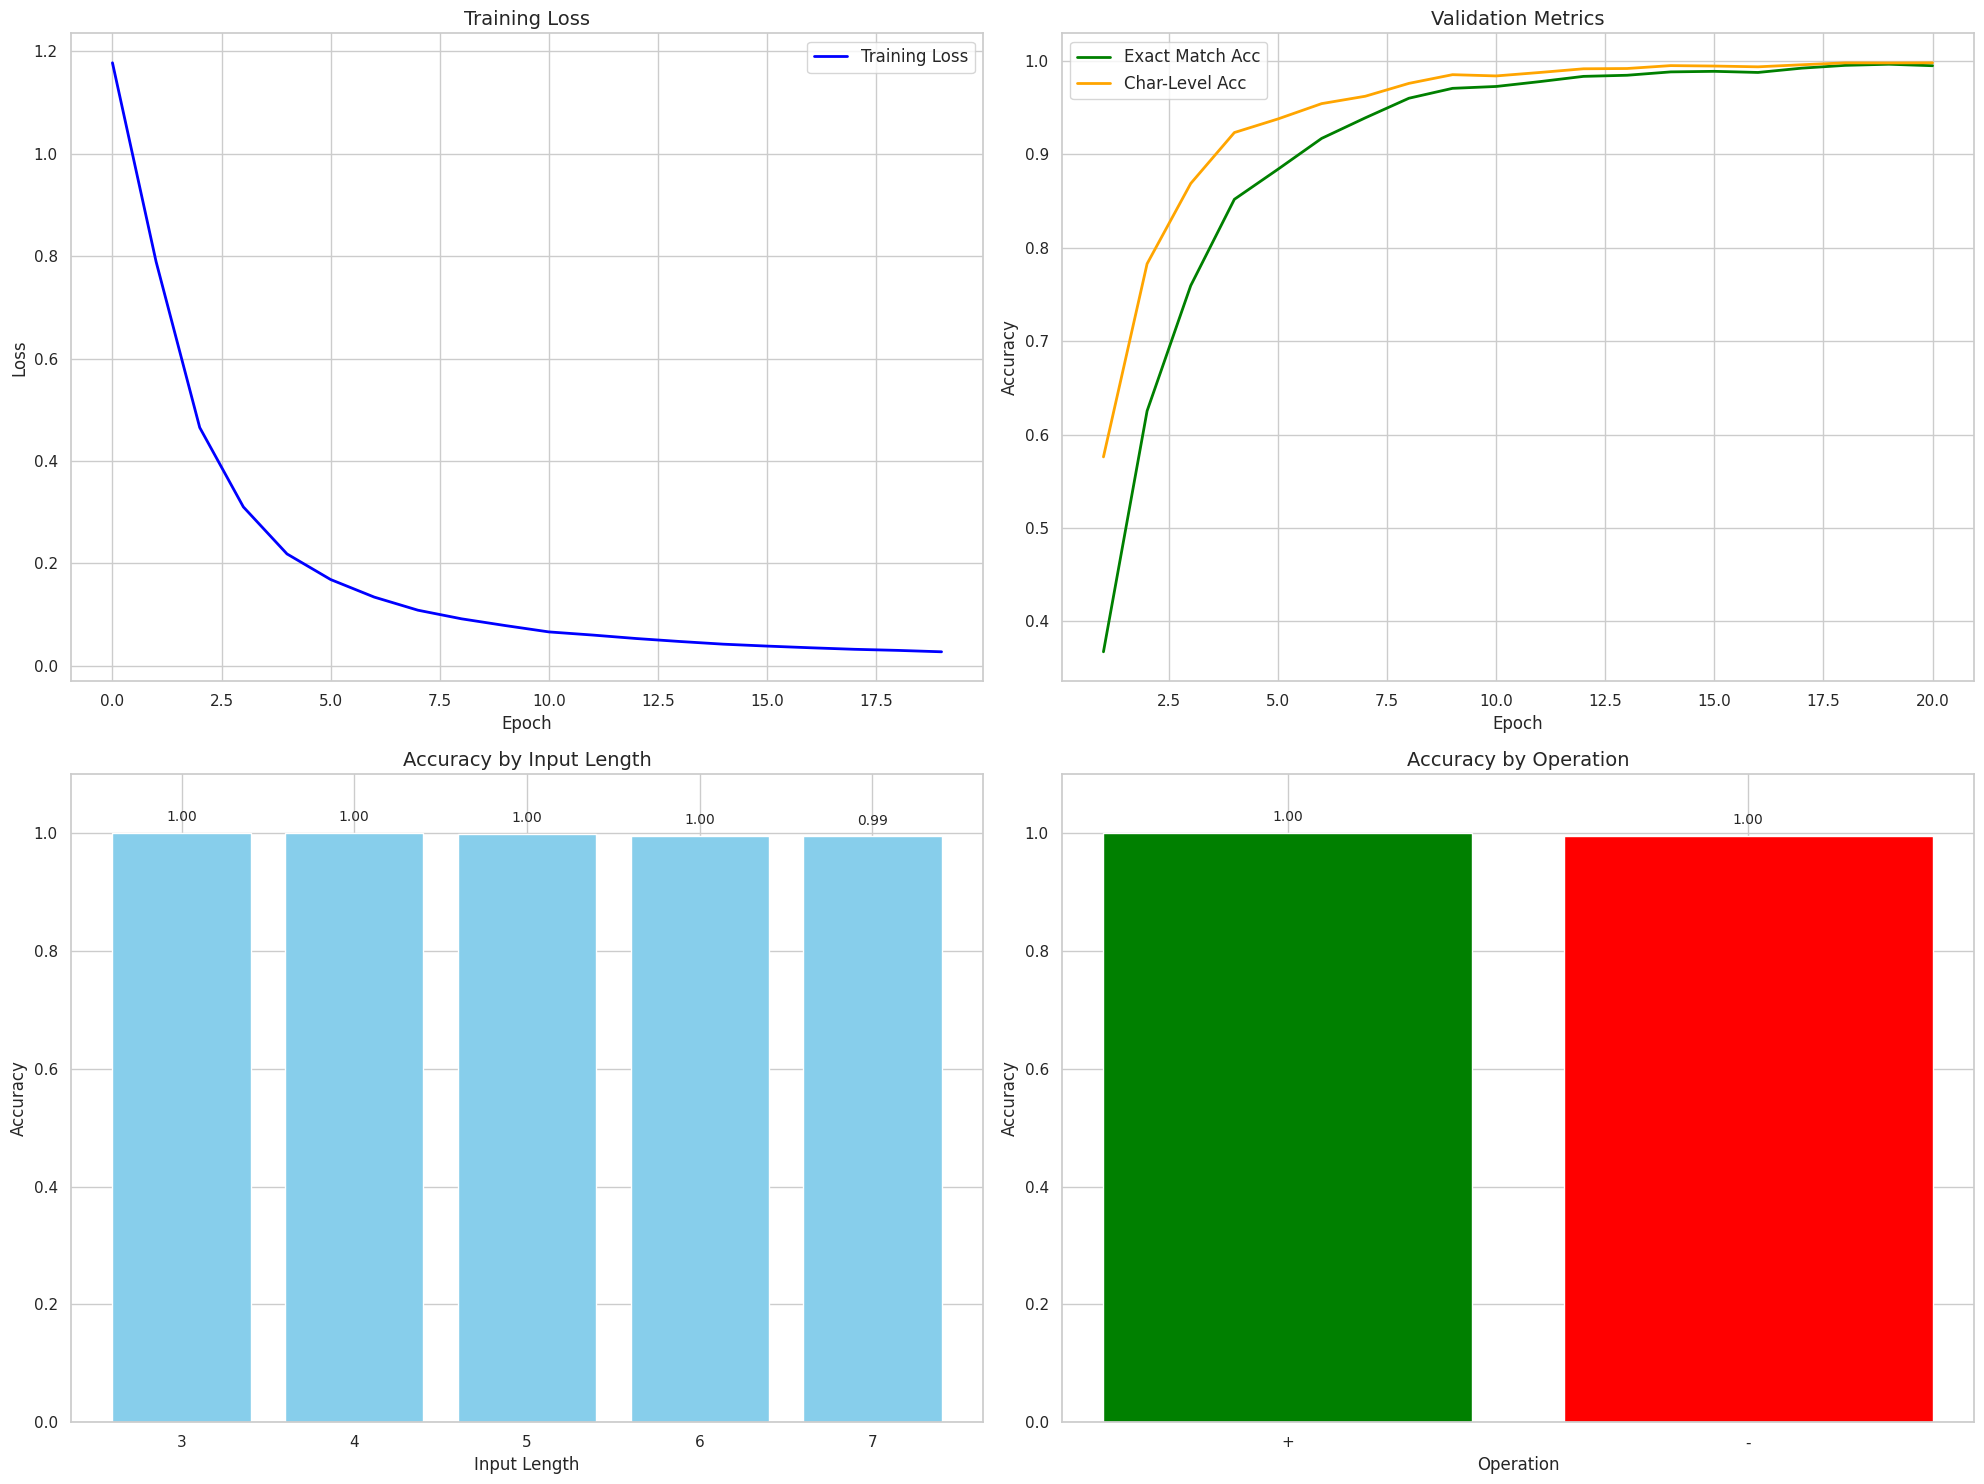

<Figure size 1500x600 with 0 Axes>

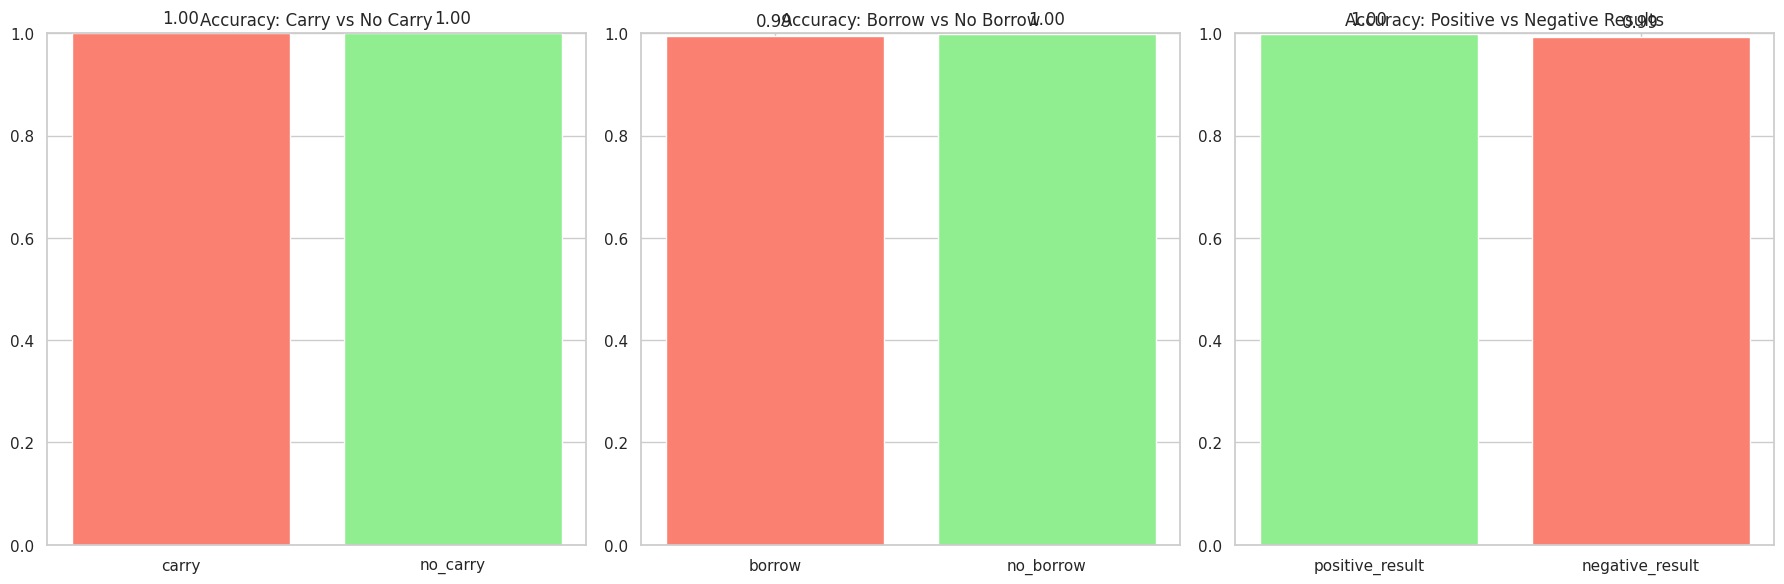

<Figure size 1800x1200 with 0 Axes>

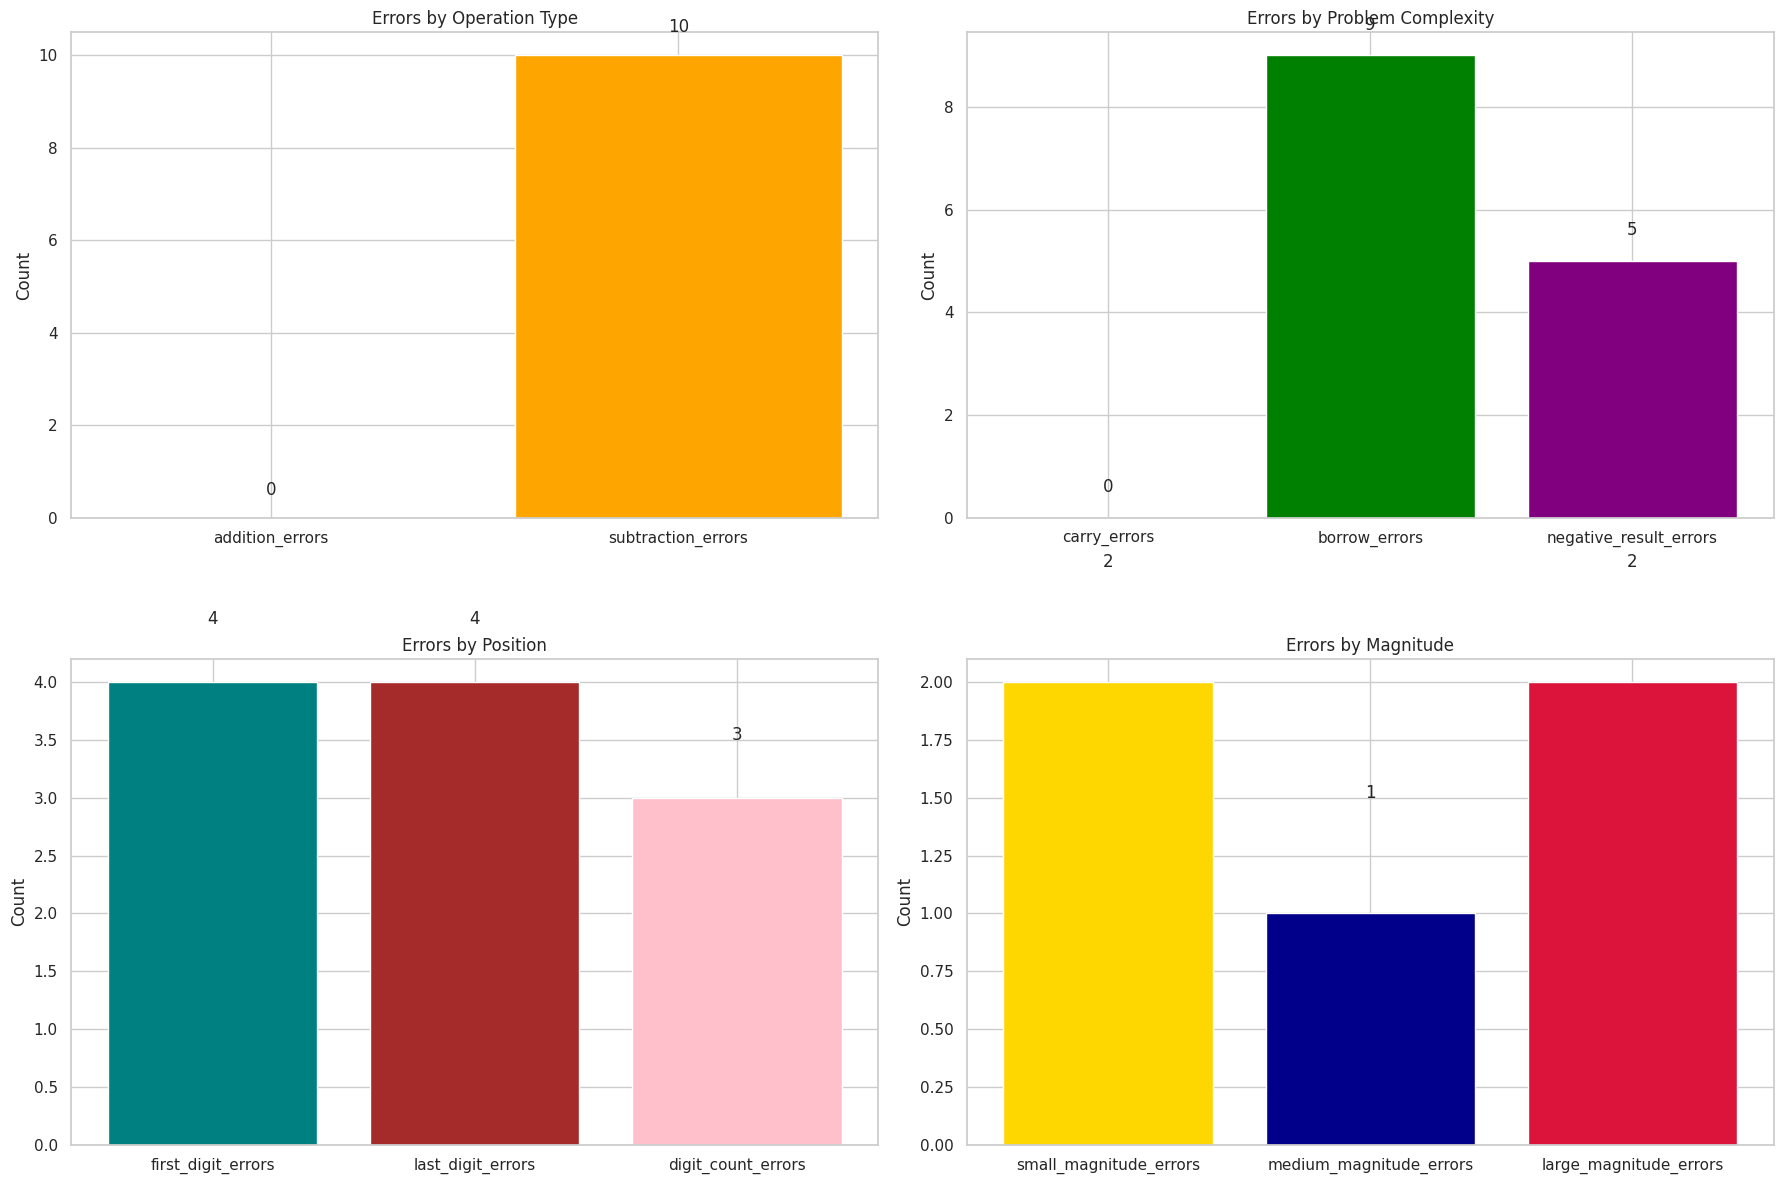


Detailed Error Examples:

Error 1:
  Input: 556-493
  Target: 63
  Prediction: 163
  Operation: -
  Has Borrow: True (Borrow Count: 1)
  Negative Result: False
  Magnitude Difference: 100
  First Digit Error: True
  Last Digit Error: False

Error 2:
  Input: 24-16
  Target: 8
  Prediction: 7
  Operation: -
  Has Borrow: True (Borrow Count: 1)
  Negative Result: False
  Magnitude Difference: 1
  First Digit Error: True
  Last Digit Error: True

Error 3:
  Input: 950-914
  Target: 36
  Prediction: 4
  Operation: -
  Has Borrow: True (Borrow Count: 1)
  Negative Result: False
  Magnitude Difference: 32
  First Digit Error: True
  Last Digit Error: True

Error 4:
  Input: 48-135
  Target: -87
  Prediction: -97
  Operation: -
  Has Borrow: True (Borrow Count: 1)
  Negative Result: True
  Magnitude Difference: None
  First Digit Error: False
  Last Digit Error: False

Error 5:
  Input: 15-515
  Target: -500
  Prediction: -400
  Operation: -
  Has Borrow: True (Borrow Count: 1)
  Negative Re

In [24]:
# # Analyze errors
# print("Analyzing errors...")
# errors = analyze_errors(model, test_loader, dataset)
# for i, error in enumerate(errors):
#     print(f"Error {i+1}:")
#     print(f"  Input: {error['input']}")
#     print(f"  Target: {error['target']}")
#     print(f"  Prediction: {error['prediction']}")
#     print(f"  Input Length: {error['input_length']}")
#     print(f"  Has Carry: {error['has_carry']}")
#     print(f"  Has Borrow: {error['has_borrow']}")
    
# # Analyze by input length
# print("Analyzing by input length...")
# length_metrics = analyze_by_input_length(model, test_loader, dataset)
    
# # Analyze by operation
# print("Analyzing by operation...")
# operation_metrics = analyze_by_operation(model, test_loader, dataset)
    
# # Visualize results
# print("Visualizing results...")
# visualize_results(train_losses, val_metrics, length_metrics, operation_metrics)
# # Analyze errors
# print("Analyzing errors...")
# errors = analyze_errors(model, test_loader, dataset)
# for i, error in enumerate(errors):
#     print(f"Error {i+1}:")
#     print(f"  Input: {error['input']}")
#     print(f"  Target: {error['target']}")
#     print(f"  Prediction: {error['prediction']}")
#     print(f"  Input Length: {error['input_length']}")
#     print(f"  Has Carry: {error['has_carry']}")
#     print(f"  Has Borrow: {error['has_borrow']}")
    
# Analyze by input length
print("Analyzing by input length...")
length_metrics = analyze_by_input_length(model, test_loader, dataset)
    
# Analyze by operation
print("Analyzing by operation...")
operation_metrics = analyze_by_operation(model, test_loader, dataset)
    
# # Visualize results
# print("Visualizing results...")
# visualize_results(train_losses, val_metrics, length_metrics, operation_metrics)


# After training and basic evaluation, perform enhanced analysis
print("Performing enhanced error analysis...")
    
# Analyze model errors with detailed categorization
detailed_errors = analyze_errors(model, test_loader, dataset, max_examples=100)
    
# Extract overall error patterns
error_patterns = analyze_error_patterns(detailed_errors)
print("\nError Pattern Summary:")
for pattern, count in error_patterns.items():
    print(f"  {pattern}: {count}")
    
# Analyze by problem complexity
print("\nAnalyzing by problem complexity...")
complexity_metrics = analyze_by_complexity(model, test_loader, dataset)
for category, metrics in complexity_metrics.items():
    print(f"  {category}: {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['total']})")
    
# Visualize standard and enhanced results
print("\nVisualizing results with enhanced analysis...")
visualize_results(
    train_losses, 
    val_metrics, 
    length_metrics, 
    operation_metrics,
    complexity_metrics,
    error_patterns
)
    
# Print some detailed error examples
print("\nDetailed Error Examples:")
for i, error in enumerate(detailed_errors[:5]):  # Show first 5 detailed errors
    print(f"\nError {i+1}:")
    print(f"  Input: {error['input']}")
    print(f"  Target: {error['target']}")
    print(f"  Prediction: {error['prediction']}")
    print(f"  Operation: {error['operation']}")
    if error['operation'] == '+':
        print(f"  Has Carry: {error['has_carry']} (Carry Count: {error['carry_count']})")
    else:
        print(f"  Has Borrow: {error['has_borrow']} (Borrow Count: {error['borrow_count']})")
        print(f"  Negative Result: {error['is_negative_result']}")
    print(f"  Magnitude Difference: {error['magnitude_diff']}")
    print(f"  First Digit Error: {error['first_digit_error']}")
    print(f"  Last Digit Error: {error['last_digit_error']}")

In [34]:
# Perform ablation study
print("Performing ablation study...")
ablation_configs = {
        'baseline': {
            'N': N, 'd_model': d_model, 'd_ff': d_ff, 'h': h, 
            'dropout': dropout, 'lr': lr, 'epochs': epochs, 'patience': patience
        },
        'fewer_layers': {
            'N': N-1, 'd_model': d_model, 'd_ff': d_ff, 'h': h, 
            'dropout': dropout, 'lr': lr, 'epochs': epochs, 'patience': patience
        },
        'smaller_model_dim': {
            'N': N, 'd_model': d_model//2, 'd_ff': d_ff//2, 'h': h//2, 
            'dropout': dropout, 'lr': lr, 'epochs': epochs, 'patience': patience
        }
    }
    
ablation_results = ablation_study(train_loader, val_loader, test_loader, gen_loader,vocab_size, dataset, ablation_configs)
    
# print("\nAblation Study Results:")
# for name, result in ablation_results.items():
#     print(f"{name}:")
#     print(f"  Best Exact Match Acc: {result['best_val_metric']['exact_match_accuracy']:.4f}")
#     print(f"  Best Char-Level Acc: {result['best_val_metric']['char_level_accuracy']:.4f}")
#     print(f"  Best Perplexity: {result['best_val_metric']['perplexity']:.4f}")
#     print(f"  Epochs Trained: {result['epochs_trained']}")
    
# print("\nTraining and evaluation complete!")
print("\n Ablation Study Results:")
for name, result in ablation_results.items():
    print(f"\n {name}:")
    
    val = result['best_val_metric']
    test = result['test_metric']
    gen = result['gen_metric']
    
    print(f"   Validation - EM: {val['exact_match_accuracy']:.4f}, Char Acc: {val['char_level_accuracy']:.4f}, PPL: {val['perplexity']:.4f}")
    print(f"   Test       - EM: {test['exact_match_accuracy']:.4f}, Char Acc: {test['char_level_accuracy']:.4f}, PPL: {test['perplexity']:.4f}")
    print(f"   Generalize - EM: {gen['exact_match_accuracy']:.4f}, Char Acc: {gen['char_level_accuracy']:.4f}, PPL: {gen['perplexity']:.4f}")
    print(f"   Epochs Trained: {result['epochs_trained']}")



Performing ablation study...

Training model with configuration: baseline


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 1/20
Train Loss: 1.6016
Validation Metrics: Exact Match Acc=0.1360, Char-Level Acc=0.3842, Perplexity=3.3070
Model saved at epoch 1


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 2/20
Train Loss: 1.1386
Validation Metrics: Exact Match Acc=0.4154, Char-Level Acc=0.5967, Perplexity=2.0622
Model saved at epoch 2


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 3/20
Train Loss: 0.7275
Validation Metrics: Exact Match Acc=0.6168, Char-Level Acc=0.7870, Perplexity=1.4345
Model saved at epoch 3


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 4/20
Train Loss: 0.4466
Validation Metrics: Exact Match Acc=0.7634, Char-Level Acc=0.8724, Perplexity=1.2219
Model saved at epoch 4


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 5/20
Train Loss: 0.2960
Validation Metrics: Exact Match Acc=0.8724, Char-Level Acc=0.9272, Perplexity=1.1259
Model saved at epoch 5


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 6/20
Train Loss: 0.2077
Validation Metrics: Exact Match Acc=0.9248, Char-Level Acc=0.9588, Perplexity=1.0708
Model saved at epoch 6


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 7/20
Train Loss: 0.1369
Validation Metrics: Exact Match Acc=0.9686, Char-Level Acc=0.9815, Perplexity=1.0319
Model saved at epoch 7


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 8/20
Train Loss: 0.0985
Validation Metrics: Exact Match Acc=0.9842, Char-Level Acc=0.9931, Perplexity=1.0164
Model saved at epoch 8


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 9/20
Train Loss: 0.0743
Validation Metrics: Exact Match Acc=0.9866, Char-Level Acc=0.9926, Perplexity=1.0148
Model saved at epoch 9


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 10/20
Train Loss: 0.0609
Validation Metrics: Exact Match Acc=0.9894, Char-Level Acc=0.9939, Perplexity=1.0120
Model saved at epoch 10


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 11/20
Train Loss: 0.0505
Validation Metrics: Exact Match Acc=0.9946, Char-Level Acc=0.9966, Perplexity=1.0068
Model saved at epoch 11


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 12/20
Train Loss: 0.0424
Validation Metrics: Exact Match Acc=0.9950, Char-Level Acc=0.9974, Perplexity=1.0043
Model saved at epoch 12


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 13/20
Train Loss: 0.0352
Validation Metrics: Exact Match Acc=0.9964, Char-Level Acc=0.9985, Perplexity=1.0042
Model saved at epoch 13


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 14/20
Train Loss: 0.0313
Validation Metrics: Exact Match Acc=0.9940, Char-Level Acc=0.9972, Perplexity=1.0052


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.32s/it]


Epoch 15/20
Train Loss: 0.0279
Validation Metrics: Exact Match Acc=0.9954, Char-Level Acc=0.9970, Perplexity=1.0050


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 16/20
Train Loss: 0.0242
Validation Metrics: Exact Match Acc=0.9978, Char-Level Acc=0.9989, Perplexity=1.0023
Model saved at epoch 16


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 17/20
Train Loss: 0.0229
Validation Metrics: Exact Match Acc=0.9994, Char-Level Acc=0.9998, Perplexity=1.0007
Model saved at epoch 17


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 18/20
Train Loss: 0.0209
Validation Metrics: Exact Match Acc=0.9994, Char-Level Acc=0.9997, Perplexity=1.0008


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 19/20
Train Loss: 0.0195
Validation Metrics: Exact Match Acc=0.9970, Char-Level Acc=0.9985, Perplexity=1.0035


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 20/20
Train Loss: 0.0183
Validation Metrics: Exact Match Acc=0.9990, Char-Level Acc=0.9995, Perplexity=1.0008
Early stopping at epoch 20


Evaluating: 100%|██████████| 79/79 [02:01<00:00,  1.54s/it]



Training model with configuration: fewer_layers


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.08it/s]


Epoch 1/20
Train Loss: 1.6381
Validation Metrics: Exact Match Acc=0.0946, Char-Level Acc=0.3417, Perplexity=3.5692
Model saved at epoch 1


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 2/20
Train Loss: 1.2693
Validation Metrics: Exact Match Acc=0.2476, Char-Level Acc=0.4819, Perplexity=2.6238
Model saved at epoch 2


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 3/20
Train Loss: 1.0133
Validation Metrics: Exact Match Acc=0.4528, Char-Level Acc=0.6486, Perplexity=1.9189
Model saved at epoch 3


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 4/20
Train Loss: 0.7180
Validation Metrics: Exact Match Acc=0.6522, Char-Level Acc=0.8057, Perplexity=1.4300
Model saved at epoch 4


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 5/20
Train Loss: 0.4636
Validation Metrics: Exact Match Acc=0.7728, Char-Level Acc=0.8788, Perplexity=1.2233
Model saved at epoch 5


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 6/20
Train Loss: 0.3237
Validation Metrics: Exact Match Acc=0.8428, Char-Level Acc=0.9118, Perplexity=1.1514
Model saved at epoch 6


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.07it/s]


Epoch 7/20
Train Loss: 0.2501
Validation Metrics: Exact Match Acc=0.8890, Char-Level Acc=0.9417, Perplexity=1.1057
Model saved at epoch 7


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.07it/s]


Epoch 8/20
Train Loss: 0.2012
Validation Metrics: Exact Match Acc=0.9182, Char-Level Acc=0.9551, Perplexity=1.0864
Model saved at epoch 8


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 9/20
Train Loss: 0.1657
Validation Metrics: Exact Match Acc=0.9340, Char-Level Acc=0.9650, Perplexity=1.0608
Model saved at epoch 9


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 10/20
Train Loss: 0.1409
Validation Metrics: Exact Match Acc=0.9470, Char-Level Acc=0.9708, Perplexity=1.0491
Model saved at epoch 10


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 11/20
Train Loss: 0.1232
Validation Metrics: Exact Match Acc=0.9590, Char-Level Acc=0.9773, Perplexity=1.0455
Model saved at epoch 11


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 12/20
Train Loss: 0.1043
Validation Metrics: Exact Match Acc=0.9620, Char-Level Acc=0.9751, Perplexity=1.0402
Model saved at epoch 12


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 13/20
Train Loss: 0.0882
Validation Metrics: Exact Match Acc=0.9746, Char-Level Acc=0.9854, Perplexity=1.0245
Model saved at epoch 13


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 14/20
Train Loss: 0.0796
Validation Metrics: Exact Match Acc=0.9758, Char-Level Acc=0.9870, Perplexity=1.0228
Model saved at epoch 14


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.07it/s]


Epoch 15/20
Train Loss: 0.0695
Validation Metrics: Exact Match Acc=0.9834, Char-Level Acc=0.9920, Perplexity=1.0157
Model saved at epoch 15


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 16/20
Train Loss: 0.0607
Validation Metrics: Exact Match Acc=0.9868, Char-Level Acc=0.9929, Perplexity=1.0149
Model saved at epoch 16


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 17/20
Train Loss: 0.0559
Validation Metrics: Exact Match Acc=0.9862, Char-Level Acc=0.9922, Perplexity=1.0143


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.08it/s]


Epoch 18/20
Train Loss: 0.0485
Validation Metrics: Exact Match Acc=0.9874, Char-Level Acc=0.9924, Perplexity=1.0103
Model saved at epoch 18


Evaluating: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s]


Epoch 19/20
Train Loss: 0.0461
Validation Metrics: Exact Match Acc=0.9910, Char-Level Acc=0.9952, Perplexity=1.0076
Model saved at epoch 19


Evaluating: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


Epoch 20/20
Train Loss: 0.0424
Validation Metrics: Exact Match Acc=0.9928, Char-Level Acc=0.9966, Perplexity=1.0081
Model saved at epoch 20


Evaluating: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it]



Training model with configuration: smaller_model_dim


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 1/20
Train Loss: 1.7448
Validation Metrics: Exact Match Acc=0.0518, Char-Level Acc=0.2798, Perplexity=4.1783
Model saved at epoch 1


Evaluating: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Epoch 2/20
Train Loss: 1.4748
Validation Metrics: Exact Match Acc=0.1062, Char-Level Acc=0.3570, Perplexity=3.3549
Model saved at epoch 2


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 3/20
Train Loss: 1.2949
Validation Metrics: Exact Match Acc=0.1680, Char-Level Acc=0.4310, Perplexity=2.8590
Model saved at epoch 3


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 4/20
Train Loss: 1.1506
Validation Metrics: Exact Match Acc=0.2658, Char-Level Acc=0.4980, Perplexity=2.5049
Model saved at epoch 4


Evaluating: 100%|██████████| 79/79 [01:44<00:00,  1.32s/it]


Epoch 5/20
Train Loss: 1.0213
Validation Metrics: Exact Match Acc=0.3674, Char-Level Acc=0.5820, Perplexity=2.1008
Model saved at epoch 5


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 6/20
Train Loss: 0.8456
Validation Metrics: Exact Match Acc=0.5572, Char-Level Acc=0.7421, Perplexity=1.6317
Model saved at epoch 6


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 7/20
Train Loss: 0.6470
Validation Metrics: Exact Match Acc=0.6874, Char-Level Acc=0.8265, Perplexity=1.3562
Model saved at epoch 7


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 8/20
Train Loss: 0.4915
Validation Metrics: Exact Match Acc=0.7876, Char-Level Acc=0.8903, Perplexity=1.2269
Model saved at epoch 8


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 9/20
Train Loss: 0.3857
Validation Metrics: Exact Match Acc=0.8350, Char-Level Acc=0.9174, Perplexity=1.1559
Model saved at epoch 9


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 10/20
Train Loss: 0.3082
Validation Metrics: Exact Match Acc=0.8870, Char-Level Acc=0.9457, Perplexity=1.1056
Model saved at epoch 10


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 11/20
Train Loss: 0.2532
Validation Metrics: Exact Match Acc=0.9190, Char-Level Acc=0.9589, Perplexity=1.0765
Model saved at epoch 11


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 12/20
Train Loss: 0.2088
Validation Metrics: Exact Match Acc=0.9436, Char-Level Acc=0.9704, Perplexity=1.0539
Model saved at epoch 12


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.32s/it]


Epoch 13/20
Train Loss: 0.1745
Validation Metrics: Exact Match Acc=0.9626, Char-Level Acc=0.9812, Perplexity=1.0404
Model saved at epoch 13


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 14/20
Train Loss: 0.1455
Validation Metrics: Exact Match Acc=0.9712, Char-Level Acc=0.9859, Perplexity=1.0291
Model saved at epoch 14


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 15/20
Train Loss: 0.1265
Validation Metrics: Exact Match Acc=0.9774, Char-Level Acc=0.9895, Perplexity=1.0238
Model saved at epoch 15


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 16/20
Train Loss: 0.1082
Validation Metrics: Exact Match Acc=0.9858, Char-Level Acc=0.9930, Perplexity=1.0152
Model saved at epoch 16


Evaluating: 100%|██████████| 79/79 [01:43<00:00,  1.31s/it]


Epoch 17/20
Train Loss: 0.1007
Validation Metrics: Exact Match Acc=0.9886, Char-Level Acc=0.9940, Perplexity=1.0151
Model saved at epoch 17


Evaluating: 100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch 18/20
Train Loss: 0.0841
Validation Metrics: Exact Match Acc=0.9874, Char-Level Acc=0.9945, Perplexity=1.0113


Evaluating: 100%|██████████| 79/79 [01:48<00:00,  1.38s/it]


Epoch 19/20
Train Loss: 0.0760
Validation Metrics: Exact Match Acc=0.9884, Char-Level Acc=0.9942, Perplexity=1.0100


Evaluating: 100%|██████████| 79/79 [01:47<00:00,  1.35s/it]


Epoch 20/20
Train Loss: 0.0707
Validation Metrics: Exact Match Acc=0.9902, Char-Level Acc=0.9958, Perplexity=1.0083
Model saved at epoch 20


Evaluating: 100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


 Ablation Study Results:

 baseline:
   Validation - EM: 0.9994, Char Acc: 0.9998, PPL: 1.0007
   Test       - EM: 1.0000, Char Acc: 1.0000, PPL: 1.0004
   Generalize - EM: 0.0000, Char Acc: 0.2103, PPL: 9739.9926
   Epochs Trained: 20

 fewer_layers:
   Validation - EM: 0.9928, Char Acc: 0.9966, PPL: 1.0081
   Test       - EM: 0.9956, Char Acc: 0.9977, PPL: 1.0060
   Generalize - EM: 0.0002, Char Acc: 0.2851, PPL: 5132.5791
   Epochs Trained: 20

 smaller_model_dim:
   Validation - EM: 0.9902, Char Acc: 0.9958, PPL: 1.0083
   Test       - EM: 0.9912, Char Acc: 0.9962, PPL: 1.0079
   Generalize - EM: 0.0000, Char Acc: 0.1585, PPL: 18453.6369
   Epochs Trained: 20


Visualizing generalization results...


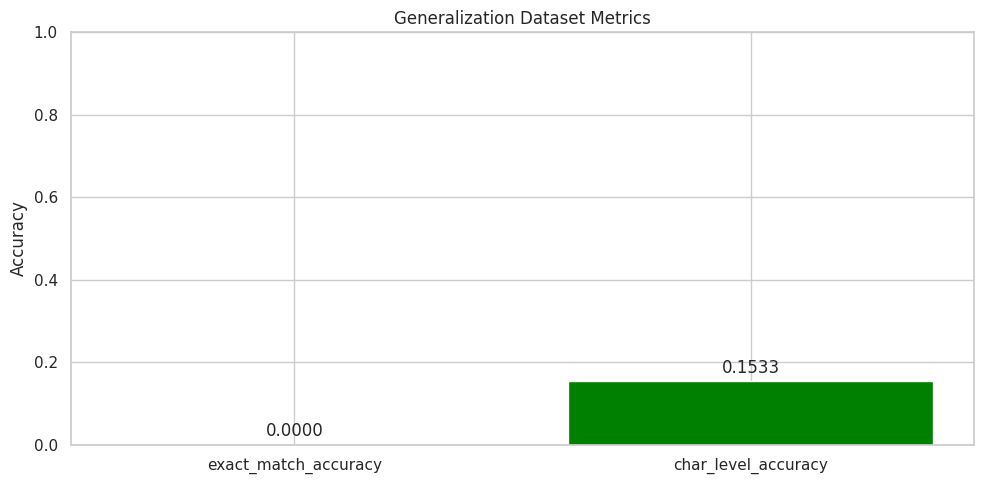

Analyzing generalization: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]


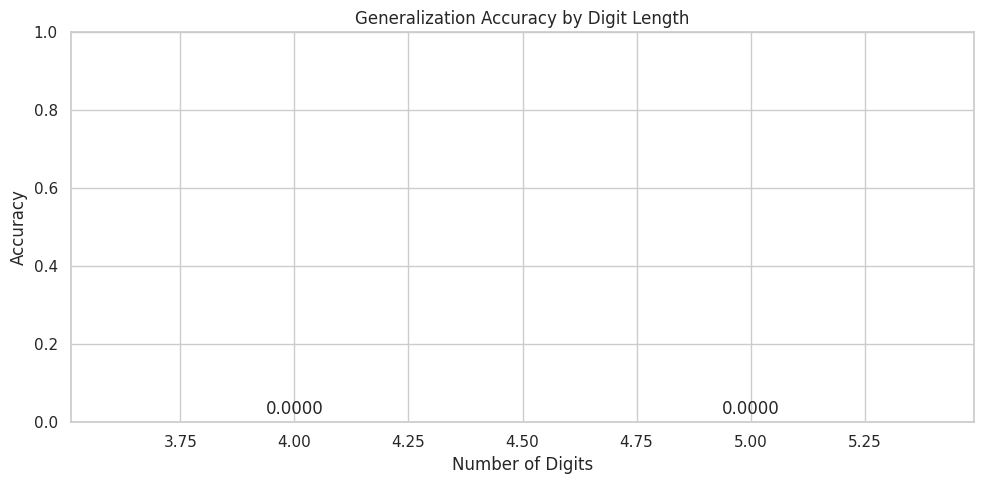

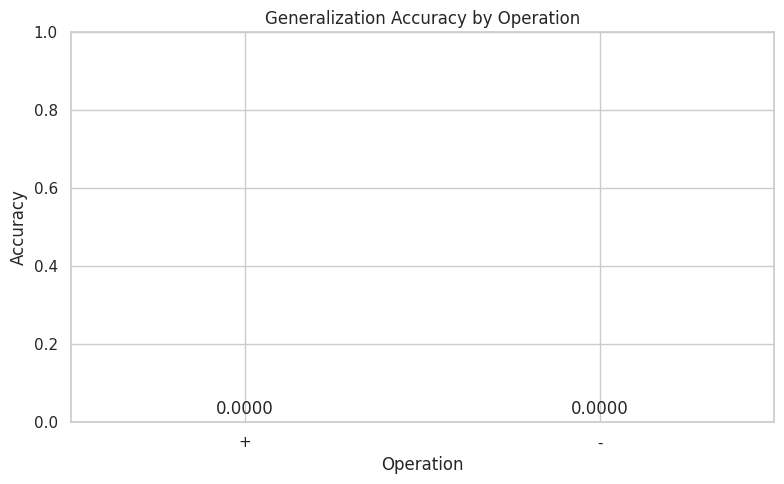


Generalization Performance by Digit Length:
4-digit numbers: 0/2500 = 0.0000
5-digit numbers: 0/2500 = 0.0000

Generalization Performance by Operation:
Operation +: 0/2463 = 0.0000
Operation -: 0/2537 = 0.0000


In [35]:
# After evaluating on generalization set
print("Visualizing generalization results...")
gen_digit_metrics, gen_op_metrics = visualize_generalization_results(gen_metrics, model, gen_loader, dataset)

# Display detailed metrics
print("\nGeneralization Performance by Digit Length:")
for length, metrics in gen_digit_metrics.items():
    print(f"{length}-digit numbers: {metrics['correct']}/{metrics['total']} = {metrics['accuracy']:.4f}")

print("\nGeneralization Performance by Operation:")
for op, metrics in gen_op_metrics.items():
    print(f"Operation {op}: {metrics['correct']}/{metrics['total']} = {metrics['accuracy']:.4f}")